# Проект для «Викишоп»

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. 

Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75. 

## 1 Подготовка данных

In [1]:
pip install pymystem3

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 

import re

import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

from sklearn.metrics import f1_score

from time import time

pd.options.display.max_columns = None 

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to C:\Users\Alex
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
nltk.download('punkt')
nltk.download('wordnet')

stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package punkt to C:\Users\Alex
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Alex
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df = pd.read_csv('toxic_comments.csv')

In [5]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


Посмотрим как отличается количество комментариев, которые считаются токсичными от позитивных

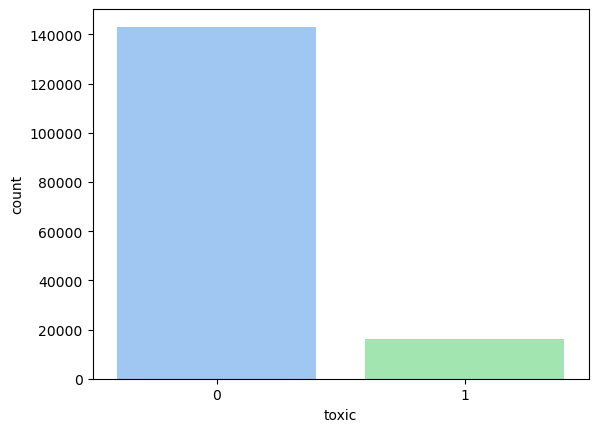

In [6]:
sns.countplot(x = 'toxic', data = df)
plt.show()

Создадим функцию для очистки текста от лишних символов

In [7]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    
    return  " ".join(text.split())

Создадим функцию внутри которой токенизируем текст, после чего лемматизируем каждый токен и объединим в текст

In [8]:
def lemmatize(words):
    lemmatizer = WordNetLemmatizer() 
    text = [] 
    tokens = word_tokenize(words) 
    for token in tokens: 
        lemmatized_word = lemmatizer.lemmatize(token) 
        text.append(lemmatized_word)
    sentence = " ".join(text) 
    return sentence

Добавим результаты работы функций в новый столбец

In [9]:
df['lemmatized'] = df['text'].apply(clear_text)
df['lemmatized'] = df['lemmatized'].apply(lemmatize)

df['lemmatized']

0         explanation why the edits made under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestion on impro...
4         you sir are my hero any chance you remember wh...
                                ...                        
159287    and for the second time of asking when your vi...
159288    you should be ashamed of yourself that is a ho...
159289    spitzer umm there no actual article for prosti...
159290    and it look like it wa actually you who put on...
159291    and i really don t think you understand i came...
Name: lemmatized, Length: 159292, dtype: object

Посмотрим на результат

In [10]:
df

,Unnamed: 0,text,toxic,lemmatized
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159288,159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159290,159449,And it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...


## 2 Подготовка признаков

Выделим признаки и целевой признак, разделим данные на обучающую и тестовую выборку, стратифицируем выборки для сохранения баланса

In [11]:
X = df.drop('toxic', axis=1)
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2,
    random_state=12345,
    stratify=y)


Выделим тренировочный и тестовый корпус

In [12]:
corpus_train = X_train['lemmatized']
corpus_test = X_test['lemmatized']
corpus_train

4627      i don t mean to intrude but i have noticed the...
23542     god or whoever whatever i now decree you the c...
128384    can we keep this neat and sequential we have a...
31111     here s what you said may rama blocked expires ...
41207     sir giggsy ha often said that he like to keep ...
                                ...                        
54715     indeed bigdunc that page rightly say that para...
75564     i m not trying to make a point or anything exc...
71196     forgive my cruddy formattingi m still relative...
55751     talk grasshopper scout i moved your comment fr...
11543                                  oppose wp commonname
Name: lemmatized, Length: 127433, dtype: object

In [13]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

tf_idf_train = count_tf_idf.fit_transform(corpus_train) 

tf_idf_test = count_tf_idf.transform(corpus_test) 

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (127433, 138910)
Размер матрицы: (31859, 138910)


## 3 Подбор параметров и обучение моделей

Создадим таблицу для конечного сравнения метрик.

In [14]:
analisys = pd.DataFrame({'model':[], 'F1_model':[], 'F1_on_train':[]})
all_models = []

Создадим функцию для подбора параметров моделей

In [15]:
def train_model(model, parameters):
    
    model_random = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters,
        scoring='f1', 
        n_jobs=-1,
        cv=4, 
        verbose=2
    )
    
    start = time()
    model_random.fit(tf_idf_train, y_train)
    print('Подбор параметров занял %.2f секунд' %(time() - start))
    
    f1 = model_random.best_score_
    f1_on_train = f1_score(y_train, model_random.predict(tf_idf_train))
    
    print('Лучшие параметры:', model_random.best_params_)
    print('F1 обученной модели:', f1)
    print('F1 на тренировочной выборке:', f1_on_train)
   
    all_models.append(model_random)
    row = []
    row.extend([model, f1, f1_on_train])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

Зададим рандомные параметры для обучения модели Логистической Регрессии

In [16]:
ran_lr = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "class_weight": ['balanced', 'none'],
}

logr = LogisticRegression(max_iter=1000)

lr_random = train_model(logr, ran_lr) 

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Подбор параметров занял 126.08 секунд
Лучшие параметры: {'penalty': 'l2', 'class_weight': 'balanced'}
F1 обученной модели: 0.7457082089350278
F1 на тренировочной выборке: 0.8299916874480466


Зададим рандомные параметры для обучения модели DecisionTreeClassifier

In [17]:
ran_grid_tree = {
    "max_depth": list(range(45, 56))
}
dtr = DecisionTreeClassifier()
dtr_random = train_model(dtr, ran_grid_tree) 

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Подбор параметров занял 243.74 секунд
Лучшие параметры: {'max_depth': 53}
F1 обученной модели: 0.704827097446376
F1 на тренировочной выборке: 0.818713981031901


Зададим рандомные параметры для обучения модели RandomForestClassifier

In [18]:
ran_grid_forest = {
    'max_depth': [300, 310],
    'n_estimators': [12, 14],
}

rfc = RandomForestClassifier(n_jobs=-1)

rfc_random = train_model(rfc, ran_grid_forest) 

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Подбор параметров занял 225.42 секунд
Лучшие параметры: {'n_estimators': 12, 'max_depth': 310}
F1 обученной модели: 0.620891914976102
F1 на тренировочной выборке: 0.910390047074647


Зададим рандомные параметры для обучения модели LGBMClassifier

In [19]:
rand_lgbm_param = {
    'max_depth': [15, 25],
    'learning_rate': [0.1, 0.3]
}

gbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_jobs=-1
)

gbm_random= train_model(gbm, rand_lgbm_param)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Подбор параметров занял 156.98 секунд
Лучшие параметры: {'max_depth': 25, 'learning_rate': 0.3}
F1 обученной модели: 0.7642287062721276
F1 на тренировочной выборке: 0.8518930005982395


## 4 Анализ результатов и тестирование лучшей модели

,model,F1_model,F1_on_train,names
0,LogisticRegression(max_iter=1000),0.745708,0.829992,LogisticRegression
1,DecisionTreeClassifier(),0.704827,0.818714,DecisionTree
2,RandomForestClassifier(n_jobs=-1),0.620892,0.910390,RandomForest
3,LGBMClassifier(),0.764229,0.851893,LightGBM


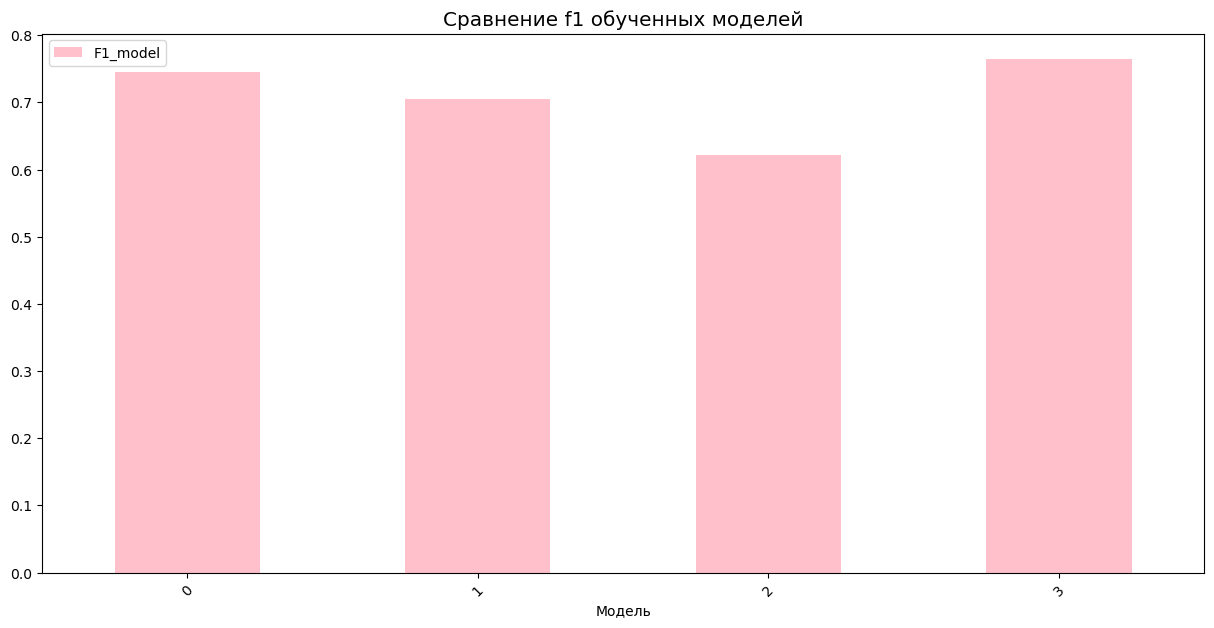

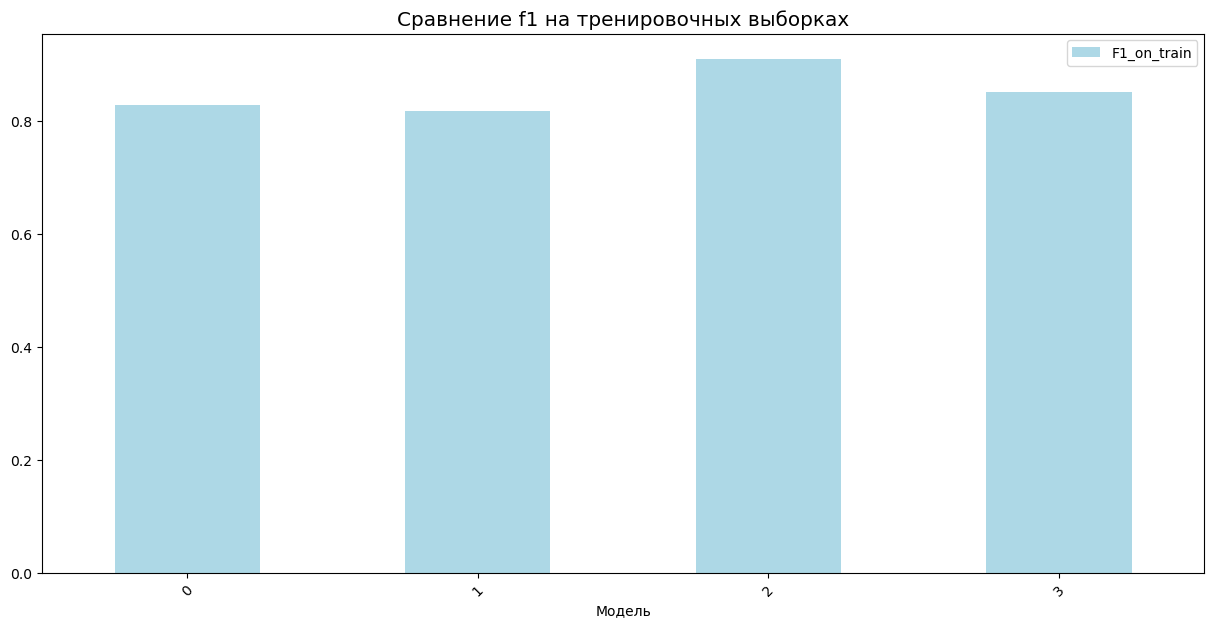

In [20]:
all_names = pd.DataFrame({'names':[ 'LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='F1_model', rot=45, figsize=(15,7), color='pink')
plt.title('Сравнение f1 обученных моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='F1_on_train', rot=45, figsize=(15,7), color='lightblue')
plt.title('Сравнение f1 на тренировочных выборках', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

Проведем тестирование на модели показавшей самую высокую метрику F1, LGBMClassifier

In [21]:
predicted = gbm_random.predict(tf_idf_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(y_test, predicted))

F1 лучшей модели на тестовой выборке: 0.7761452031114953


## 5 Вывод

В ходе выполнения проектной работы был загружен набор данных с разметкой о токсичности правок.

Тексты правок были очищены от "лишних" символов и приведены к нижнему регистру.
Далее, все тексты были лемматизированы и добавлены в датасет в качестве обучающих признаков.

На этапе подготовки признаков к обучению набор данных был разбит на признаки и целевой признак, а так же на обучающую и тестовую выборки.
Были подготовлены корпусы текстов, обучающий и тестовый, были очищенны от стоп-слов, так же проведена векторизация.
При помощи метода RandomizedSearchCV был произведен подбор параметров для четырех моделей:

- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- LGBMClassifier

Самую высокую метрику F1 продемонстировала модель LGBMClassifier, на этой же модели было проведено итоговое тестирование, метрика F1 составила 0,776.
Целью настоящего исследования было заявлено построение модели со значением метрики качества F1 не меньше 0.75. Цель исследования достигнута.